# Backend

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

import pandas as pd
from sklearn.cluster import DBSCAN

from sklearn.cluster import DBSCAN
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import warnings
from scipy.stats import expon

## Definitions

In [2]:
def plot_scale_bar(nm_per_pixel):
    """Adds a scale bar to the current plot

    Args:
        nm_per_pixel (int or float): The conversion ratio for scaling
    """
    fontprops = fm.FontProperties(size=8)
    scalebar = AnchoredSizeBar(plt.gca().transData,
                            1000/nm_per_pixel,  # length of scale bar
                            '1 micron',  # label
                            'lower right',  # position
                            pad=0.1,
                            color='white',
                            frameon=False,
                            size_vertical=0.05,
                            fontproperties=fontprops)
    plt.gca().add_artist(scalebar)

class PlotColors():
    """
    A class used to cycle through a set of colors for plotting.

    Attributes:
        colors (list): The list of colors to cycle through.
        current_index (int): The current index in the colors list.

    Methods:
        get_next_color(): Returns the next color in the list, looping back to the start if 
                          the end is reached.
        __getitem__(idx): Returns the color at the specified index.
    """
    def __init__(self, colors):
        """Initializes the PlotColors class.

        Args:
            colors (list): The list of colors to cycle through.
        """
        self.colors = colors
        self.current_index = 0
    
    def get_next_color(self):
        """Returns the next color in the list, looping back to the start if the end is reached.

        Returns:
            str: The next color in the list.
        """
        color_to_return = self.colors[self.current_index]
        if self.current_index == len(self.colors) - 1:
            self.current_index = 0
        else:
            self.current_index += 1
        return color_to_return
    
    def __getitem__(self, idx):
        """Returns the color at the specified index.

        Args:
            idx (int): The index of the color to access.

        Returns:
            str: The color at the specified index.
        """
        return self.colors[idx]
    
class Frames():
    """
    A class used to represent store on/off times (or 'frames on') for points.

    Attributes:
        frames (numpy.ndarray): The 'on' frames of the points.
        time_per_frame (float): The time per frame.
        max_frame (int): The maximum frame number for the dataset.

    Methods:
        __len__() -> int: Returns the number of frames.
        __getitem__(idx: int) -> numpy.ndarray: Returns the frame at the specified index.
        __max__() -> int: Returns the maximum frame number.
        __min__() -> int: Returns the minimum frame number.
        get_dark_times() -> list: Calculates and returns the dark times (times between 'on' points).
        get_average_dark_time(plot: bool, return_max: bool) -> float or tuple: Calculates the 
            average dark time and optionally returns the maximum dark time.
    """
    def __init__(self, frames, time_per_frame, max_frame=None):
        """ Initializes the Frames class.

        Args:
            frames (list[int]): The list of 'on' frames.
            time_per_frame (float): The time per frame.
            max_frame (int, optional): The maximum frame number for the dataset. 
                If None, the maximum frame will be calculated from the input frames.
                Should only be None if using for BasePoints.
        """
        self.frames = np.array(frames)
        self.time_per_frame = time_per_frame
        if max_frame is None:
            self.max_frame = max(self)
        else:
            self.max_frame = max_frame
    
    def __len__(self):
        """Defines the "length" of the object as the number of frames.

        Returns:
            int: Number of frames.
        """
        return len(self.frames)
    
    def __getitem__(self, idx):
        """Defines object index access for the frames.

        Args:
            idx (int): The index of the frame to access.

        Returns:
            numpy.ndarray: The frame at the specified index.
        """
        return self.frames[idx]
    
    def __max__(self):
        """Defines the maximum frame number.

        Returns:
            int: The maximum frame number.
        """
        return max(self.frames)
    
    def __min__(self):
        """Defines the minimum frame number.

        Returns:
            int: The minimum frame number.
        """
        return min(self.frames)
    
    def get_dark_times(self):
        """Calculates the dark times (the times in between 'on' points).

        Returns:
            list: List of dark times.
        """
        times_on = [0.0]
        times_on.extend([frame*self.time_per_frame for frame in self.frames])
        times_on.extend([self.max_frame*self.time_per_frame])
        dark_times = [times_on[i] - times_on[i-1] 
                      for i in range(1, len(times_on))]
        return dark_times

    def get_average_dark_time(self, plot=False, return_max=False):
        """Calculates the average dark time.

        Args:
            plot (bool, optional): Whether to plot the dark times. Default is False.
            return_max (bool, optional): Whether to return the maximum dark time. Default is False.

        Returns:
            float or tuple: If return_max is False, returns the average dark time. 
            If return_max is True, returns a tuple of (max_dark_time, average_dark_time).
        """
        dark_times = self.get_dark_times()
        max_dark_time = max(dark_times)
        dark_times_reduced = dark_times[1:len(dark_times)-1]
        loc, scale = expon.fit(dark_times_reduced)
        if plot:
            x = np.linspace(expon.ppf(0.01, loc, scale),
                            expon.ppf(0.99, loc, scale), 100)
            pdf = expon.pdf(x, loc, scale)
            plt.hist(dark_times_reduced, bins=20, density=True, alpha=0.5)
            plt.plot(x, pdf, 'r-', lw=2)
            plt.show()
        if return_max:
            return max_dark_time, scale
        return scale   

class ClusterParam():
    """
    A class used to store clustering parameters (eps and min_samples) for DBSCAN and label 
    for the points to cluster.

    Attributes:
        eps (float): The maximum distance between two samples for them to be considered as in the 
            same neighborhood.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as 
            a core point.
        params (tuple): A tuple containing eps and min_samples parameters.
        density (float): The density of the cluster, calculated as min_samples divided by the area 
            of the cluster.
        label (str): Label for the points to cluster.

    Methods:
        __eq__(other: ClusterParam) -> bool: Checks if the current instance is equal to the 
            'other' instance.
        __lt__(other: ClusterParam) -> bool: Checks if the current instance's density is less 
            than the 'other' instance's.
        __gt__(other: ClusterParam) -> bool: Checks if the current instance's density is greater 
            than the 'other' instance's.
        __le__(other: ClusterParam) -> bool: Checks if the current instance's density is less than 
            or equal to the 'other' instance's.
        __ge__(other: ClusterParam) -> bool: Checks if the current instance's density is greater 
            than or equal to the 'other' instance's.
        __str__() -> str: Returns a string representation of the instance.
        __repr__() -> str: Returns a string representation of the instance suitable for development.
        __hash__() -> int: Returns the hash value of the instance.
        __getitem__(idx: int) -> float or int: Returns the eps or min_samples value based on the index.
    """
    def __init__(self, eps, min_samples, label=""):
        """
        Initializes the ClusterParam class.

        Args:
            eps (float): The maximum distance between two samples for one to be considered 
                as in the neighborhood of the other. This is not a maximum bound on the 
                distances of points within a cluster.
            min_samples (int): The number of samples in a neighborhood for a point to be 
                considered as a core point.
            label (str, optional): Label for the points to cluster. Default is an empty string.
        """
        self.eps = eps
        self.min_samples = min_samples
        self.params = (eps, min_samples)
        self.density = min_samples / (np.pi * (eps ** 2))
        self.label=label

    def __eq__(self, other):
        """ 
        Checks if the current instance is equal to the 'other' instance.

        Args:
            other (ClusterParam): The other instance of ClusterParam.

        Returns:
            bool: True if the current instance is equal to the 'other' instance, False otherwise.
        """
        if not isinstance(other, ClusterParam):
            return NotImplemented
        return (self.eps == other.eps and 
                self.min_samples == other.min_samples and 
                self.label == other.label)
    
    def __lt__(self, other):
        """ 
        Checks if the current instance's density is less than the 'other' instance's.

        Args:
            other (ClusterParam): The other instance of ClusterParam.

        Returns:
            bool: True if the current instance's density is less than the 'other' instance's, 
                  False otherwise.
        """
        return self.density < other.density
    
    def __gt__(self, other):
        """ 
        Checks if the current instance's density is greater than the 'other' instance's.

        Args:
            other (ClusterParam): The other instance of ClusterParam.

        Returns:
            bool: True if the current instance's density is greater than the 'other' instance's, 
                  False otherwise.
        """ 
        return self.density > other.density
    
    def __le__(self, other):
        """ 
        Checks if the current instance's density is less than or equal to the 'other' instance's.

        Args:
            other (ClusterParam): The other instance of ClusterParam.

        Returns:
            bool: True if the current instance's density is less than or equal to the 'other' 
                  instance's, False otherwise.
        """
        return self.density <= other.density
    
    def __ge__(self, other):
        """ 
        Checks if the current instance's density is greater than or equal to the 'other' instance's.

        Args:
            other (ClusterParam): The other instance of ClusterParam.

        Returns:
            bool: True if the current instance's density is greater than or equal to the 'other' 
                  instance's, False otherwise.
        """
        return self.density >= other.density
    
    def __str__(self):
        """ 
        Returns a string representation of the instance.

        Returns:
            str: A string representation of the instance in the format 
                 "label(eps=eps, min_samples=min_samples)".
        """
        return f"{self.label}(eps={self.eps}, min_samples={self.min_samples})"
    
    def __repr__(self):
        """ 
        Returns a string representation of the instance suitable for development.

        Returns:
            str: A string representation of the instance in the format 
                 "label(eps=eps, min_samples=min_samples)".
        """ 
        return f"{self.label}(eps={self.eps}, min_samples={self.min_samples})"
    
    def __hash__(self):
        """ 
        Returns the hash value of the instance.

        Returns:
            int: The hash value of the instance, computed as the hash of a tuple containing 
                 eps, min_samples, and label.
        """
        return hash((self.eps, self.min_samples, self.label))
    
    def __getitem__(self, idx):
        """ 
        Returns the eps or min_samples value based on the index.

        Args:
            idx (int): The index (0 or 1) to access eps or min_samples, respectively.

        Returns:
            float or int: The eps or min_samples value based on the index.

        Raises:
            IndexError: If an index other than 0 or 1 is provided.
        """
        if idx == 0:
            return self.eps
        elif idx == 1:
            return self.min_samples
        else:
            raise IndexError("""Only indices 0 (eps) and 1 (min_samples)
                              are valid for ClusterParam""")

class BasePoints:
    """BasePoints class to handle points and basic plotting functionality.
    
    This class provides basic functionality to manipulate and plot points in 2D space.

    Attributes:
        label (str): Label for the class instance.
        frames (Frames): The Frames associated with these points for data that contains frames.
        nm_per_pixel (float): Scale conversion for points.
        points (np.ndarray): Points to be handled or plotted.
        plot_args (dict): Dictionary for arguments to use in plot functions.

    Methods:
        __init__(): Initialize the BasePoints class.
        __len__(): Get the number of points.
        __getitem__(): Access a specific point.
        set_plot_args(): Set the arguments to use in plot functions.
        add_to_plot(): Add the points to an existing plot.
        plot(): Plot the points.
    """
    def __init__(self, points, frames=None, nm_per_pixel=1, **kwargs):
        """
        Initialize the BasePoints class.
        
        Args:
            points (list or np.ndarray): List or array of points to handle or plot.
            frames (Frames): The Frames associated with these points for data that contains frames.
            nm_per_pixel (float): Scale conversion for points. Defaults to 1.
            **kwargs: Additional arguments for plotting.
        """
        self.label = kwargs.get('label')
        self.frames = frames
        self.nm_per_pixel = nm_per_pixel
        self.points = np.array(points)
        self.plot_args = kwargs

    def __len__(self):
        """Return the number of points."""
        return len(self.points)

    def __getitem__(self, idx):
        """
        Access a specific point.
        
        Args:
            idx (int): Index of the point.

        Returns:
            np.ndarray: The point at index `idx`.
        """
        return self.points[idx]

    def set_plot_args(self, **kwargs):
        """
        Set the arguments to use in plot functions.
        
        Args:
            **kwargs: Arguments for plotting.
        """
        self.plot_args = kwargs
        
    def add_to_plot(self, **kwargs):
        """
        Add the points to an existing plot.
        
        Args:
            **kwargs: Additional arguments for plotting.
        """
        args = {**self.plot_args, **kwargs}
        plt.scatter(self.points[:, 0], self.points[:, 1], **args)

    def plot(self, **kwargs):
        """
        Plot the points.
        
        Args:
            **kwargs: Additional arguments for plotting.
        """
        args = {**self.plot_args, **kwargs}
        if args.get('color') == 'white':
            args['color'] = 'black'
        plt.figure()
        self.add_to_plot(**args)
        if self.label is not None:
            plt.title(self.label)
        plt.show()

class SubPoints(BasePoints):
    """SubPoints class to handle a subset of points from a BasePoints object.
    
    This class is a subclass of the BasePoints class and is used for handling a subset of points 
    from a BasePoints object.

    Attributes:
        indices (np.ndarray): Indices of the points to be handled from the BasePoints object.
        base_points (BasePoints): The original BasePoints object from which the subset is derived.

    Methods:
        __init__(): Initialize the SubPoints class.
        get_base_index(): Get the index of a point in the original BasePoints object.
    """
    def __init__(self, base_points, indices, **kwargs):
        """
        Initialize the SubPoints class.
        
        Args:
            base_points (BasePoints): The BasePoints object from which the subset of points is derived.
            indices (list or np.ndarray): The indices of the points to be handled.
            **kwargs: Additional arguments for plotting.
        """
        super().__init__(base_points[indices], base_points.frames, 
                         base_points.nm_per_pixel, **kwargs)
        self.indices = np.array(indices)
        if self.frames is not None:
            self.frames = Frames(self.frames[indices], self.frames.time_per_frame, 
                                 self.frames.max_frame)
        self.plot_args = {**base_points.plot_args, **self.plot_args}
        self.base_points = base_points

    def get_base_index(self, idx):
        """
        Get the index of a point in the original BasePoints object.
        
        Args:
            idx (int): The index of the point in the current SubPoints object.

        Returns:
            int: The index of the point in the original BasePoints object.
        """
        return self.indices[idx]

class Cluster(SubPoints):
    """Cluster class to handle a cluster of points from a BasePoints object.

    This class is a subclass of the SubPoints class and is used to handle a cluster of points 
    from a BasePoints object, it is also meant to be attached to a FieldOfView class 

    Attributes:
        cluster_center (np.ndarray): The center point of the cluster.
        fov (FOV): The FieldOfView class the cluster is attached to.
        nearby_points (BasePoints or None): Nearby points to the cluster.
        max_dark_time (float): Maximum dark time calculated from the associated frames.
        average_dark_time (float): Average dark time calculated from the associated frames.

    Methods:
        __init__(): Initialize the Cluster class.
        __str__(): Returns a string representation of the Cluster object.
        __repr__(): Returns a developer-friendly representation of the Cluster object.
        distance_from(): Calculate the Euclidean distance from the cluster center to a given point.
        plot_life_act(): Helper function for plot() to plot 'life_act'
        plot_homers(): Helper function for plot() to plot 'homers'
        plot(): Generate a comprehensive plot with different components based on the arguments.
    """
    def __init__(self, base_points, indices, fov=None, nearby_points=None, **kwargs):
        """
        Initialize the Cluster class.

        Args:
            base_points (BasePoints): The BasePoints object from which the subset of points is derived.
            indices (list or np.ndarray): The indices of the points to be handled.
            fov (FieldOfView, optional): The field of view related to the cluster.
            nearby_points (BasePoints or None, optional): Nearby points related to the cluster.
            **kwargs: Additional arguments for plotting.
        """
        super().__init__(base_points, indices, **kwargs)
        self.cluster_center = self.points.mean(axis=0)
        self.fov = fov
        self.nearby_points = nearby_points
        dark_times = self.frames.get_average_dark_time(return_max=True)
        self.max_dark_time, self.average_dark_time = dark_times
    
    def __str__(self):
        """Returns a string representation of the Cluster object."""
        return f"ClusterAt{self.cluster_center})"
    
    def __repr__(self):
        """Returns a developer-friendly representation of the Cluster object."""
        return f"ClusterAt{self.cluster_center})"
    
    def distance_from(self, point):
        """
        Calculate the Euclidean distance from the cluster center to a given point.

        Args:
            point (np.ndarray or list): A point in the same dimensional space as the cluster center.

        Returns:
            float: The Euclidean distance from the cluster center to the given point.
        """
        return np.linalg.norm(self.cluster_center - point)

    def plot_life_act(self, life_act):
        """
        Helper function for plot() to plot the background 'life_act'

        Args:
            life_act (bool or array-like): The 'life_act' data to plot.
        """
        if not isinstance(life_act, bool):
            plt.imshow(life_act, cmap='hot', origin='lower')
        elif life_act:
            if self.fov is None:
                print("No FOV attached to cluster, cannot plot life_act")
            else:
                if self.fov.life_act is None:
                    print("FieldOfView.life_act = None")
                    return
                plt.imshow(self.fov.life_act, cmap='hot', origin='lower')

    def plot_homers(self, homers):
        """
        Helper function for plot() to plot the homer centers.

        Args:
            homers (bool or BasePoints): The 'homers' data to plot.
        """
        if not isinstance(homers, bool):
            if not isinstance(homers, BasePoints):
                homers_type = f"{type(homers)}"
                raise Exception(f"'homers' is not of class BasePoints, instead: " + homers_type)
            homers.add_to_plot()
        elif homers:
            if self.fov is None:
                print("No FOV attached to cluster, cannot plot homers")
            else:
                if self.fov.all_homer_centers is None:
                    print("FieldOfView.all_homer_centers = None")
                    return
                self.fov.all_homer_centers.add_to_plot()
    
    def plot(self, buffer=100, print_center=True, legend=True, scale_bar=True, time_limits=None, 
             nearby_points=False, all_points=False, homers=True, life_act=True, **kwargs):
        """
        Generate a comprehensive plot with different components based on the arguments. Will plot
        both the localizations of the cluster and its surrounding region as well as the on/off
        timeline plot.

        Args:
            buffer (int, optional): Buffer distance (nm) around the cluster. Default is 100 (nm).
            print_center (bool, optional): Whether to print the cluster center. Default is True.
            legend (bool, optional): Whether to include a legend in the plot. Default is True.
            scale_bar (bool, optional): Whether to include a scale bar in the plot. Default is True.
            time_limits (list or None, optional): Time limits for the plot in the format [min, max]. 
                Default is None.
            nearby_points (bool, optional): Whether to plot nearby points. Default is False.
            all_points (bool, optional): Whether to plot all points from the base set. 
                Default is False.
            homers (bool, optional): Whether to plot homer centers. Default is True.
            life_act (bool, optional): Whether to plot the life act background. Default is True.
            **kwargs: Additional arguments for plotting.

        """
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)

        nm_per_pixel = self.nm_per_pixel
        cluster_points = self.points
        cluster_center = self.cluster_center
        self.plot_life_act(life_act)
        if all_points:
            self.base_points.add_to_plot()
        if nearby_points:
            self.nearby_points.add_to_plot()
        self.add_to_plot(**kwargs) # Plots this cluster
        self.plot_homers(homers)
        if print_center:
            plt.scatter(cluster_center[0], cluster_center[1], marker='x', 
                        linewidth=10, s=5, color='red', label="Cluster Center")
        
        if scale_bar:
            plot_scale_bar(nm_per_pixel)
        if life_act:
            plt.title(f"{self.label} [Background: Life_act]")
        else:
            plt.title(f"{self.label}")
        if legend:
            # Increase icon sizes in legend so you can actually see the points
            for handle in plt.legend().legend_handles:
                handle._sizes = [50]
        buffer = buffer / nm_per_pixel
        plt.xlim(np.min(cluster_points[:, 0]) - buffer, np.max(cluster_points[:, 0]) + buffer)
        plt.ylim(np.min(cluster_points[:, 1]) - buffer, np.max(cluster_points[:, 1]) + buffer)
        
        # Timeline plot
        plt.subplot(1, 2, 2)
        cluster_frames = self.frames.frames
        time_per_frame = self.frames.time_per_frame
        frame_range = range(max(self.base_points.frames))
        times = [frame*time_per_frame for frame in frame_range]
        vals = [1 if frame in cluster_frames else 0 for frame in frame_range]
        plt.plot(times, vals)
        plt.title(f"Timeline for {self.label} [{len(cluster_frames)} events]")
        plt.xlabel("Time (s)")
        plt.ylabel("On [1] or Off [0]")
        plt.ylim(0, 1.3)
        if time_limits is not None:
            plt.xlim(time_limits[0], time_limits[1])
        plt.tight_layout()
        plt.show()

class FieldOfView():
    """Class to hold and process all data within a single field of view
    
    This class is the main class the user will interact with in order to load data such as life act,
    homer centers, and points to examine for clustering. It includes multiple functions for
    plotting the data in a variety of ways for analysis. 
    
    Attributes:
        all_homer_centers (BasePoints): All homer centers found in the data.
        active_homer_centers (SubPoints): All homer centers which pass life act thresholding.
        life_act (np.ndarray): The background life act frame.
        Points (list[BasePoints]): A list containing all of the different points to analyze.
        Params (list[ClusterParam]): A list containing all of the ClusterParams used for clustering.
        clustering_results (dict[ClusterParam, list[Cluster]]): A dictionary containing the results
            from clustering in a list with the keys being the ClusterParam parameters used to find
            those clusters.


    Methods:
        __init__(): Initialize the FieldOfView class.
        locate_homer_centers(): Loads Homer centers from file for the class
        load_life_act(): Load life_act for the class.
        load_points(): Loads points for the class
        find_instance_by_label(): Find an instance of a class in a list by label.
        threshold_homers(): Apply a threshold to the homer centers based on the background life act.
        find_clusters(): Locate clusters of Points in the overall FOV using DBSCAN.
        add_params(): Process Params, and call out to self.find_clusters().
        plot_homer(): Plot the region around a homer center
        cluster_size_hisogram(): Plots of histogram of the calculated size of clusters.
        cluster_size_by_distance_to_homer_center(): Plots cluster size vs. distance to nearest 
            homer center.
    """
    def __init__(self, homer_centers, life_act, nm_per_pixel=1, points=[], 
                 Params=[], threshold=0, to_print=True):
        """
        Initialization function for FieldOfView class
        
        Args:
            homer_centers (str or BasePoints): either path to file containing homer centers or 
                BasePoints class with homer centers
            life_act (str or array-like): either path to file containing life act movie or 
                already loaded life_act FOV
            nm_per_pixel (int or float): conversion ratio from nm to pixels for this FOV
            points (list[list[str label, str path, str color, float time_per_frame]): 
                list containing sublists for each set of points containing the label for those
                points, the path to their csv file, the color, and the time per frame in seconds.
            Params (list[ClusterParam], optional): list containing predefined ClusterParams objects 
                for DBSCAN clustering. Defaults to [].
            threshold (int or float, optional): threshold value of life_act for a homer center to be 
                included in self.active_homers. Defaults to 0.
            to_print (bool, optional): prints initialization progress. Defaults to False.
        """
        self.nm_per_pixel = nm_per_pixel
        if isinstance(homer_centers, str):
            if to_print: print("Loading Homer Centers...")
            self.locate_homer_centers(homer_centers)
        else:
            self.all_homer_centers = homer_centers
        if to_print: print("Loading Life Act...")
        self.life_act = self.load_life_act(life_act)
        self.threshold_homers(threshold)
        self.Points = []
        if not isinstance(points[0], list):
            points = [points]
        for point in points:
            if to_print: print(f"Loading {point[0]}...")
            self.Points.append(self.load_points(point[0], point[1], point[2], 
                                                point[3], self.nm_per_pixel))
        self.Params = []
        self.clustering_results = {}
        self.add_params(Params, to_print)
    
    def locate_homer_centers(self, homer_path, plot=False):
        """
        Load Homer data from a CSV or Excel file and identify Homer centers using DBSCAN clustering.
        
        Homer centers are converted to pixel coordinates and stored as a BasePoint object in 
        self.all_homer_centers.

        Args:
            homer_path (str): The file path to the CSV or Excel file containing Homer data. 
                The file should have the format output by ThunderSTORM, with localization data in 
                columns 2 and 3 (0-indexed).
            plot (bool, optional): If True, a scatter plot of the identified Homer centers is 
                displayed. Defaults to False.

        Raises:
            FileNotFoundError: If the file specified by homer_path does not exist.
            ValueError: If the file specified by homer_path does not have the expected format.
        
        Note:
            The DBSCAN clustering uses a radius of 50 nm and requires a minimum of 5 points per 
            cluster. Clusters identified by DBSCAN are considered to be potential Homer centers, 
            and the mean position of each cluster is used as the position of the corresponding 
            Homer center.
        """
        dim = 2
        synapse_size = 50  # cluster size in nm
        min_neighbours = 5  # minimum number of neighbours w/n synapse_size radius
        try:
            ThunderSTORM = pd.read_csv(homer_path, sep=',', skiprows=1, header=None).values
        except Exception:
            ThunderSTORM = pd.read_excel(homer_path, header=None).values
        data_Syn = ThunderSTORM[:, 2:2+dim]

        # Finding clusters
        db = DBSCAN(eps=synapse_size, min_samples=min_neighbours, metric='euclidean').fit(data_Syn)
        Class = db.labels_
        type_ = np.array([1 if label != -1 else 0 for label in Class])

        # Make new matrix
        cluster_avgs = []
        Syn = np.column_stack((data_Syn, Class, type_))

        # Separate and plot clusters
        if plot: plt.figure()

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, dim] == k]
                cluster_avgs.append((sum(cluster_points[:, 0])/len(cluster_points[:, 0]), 
                                     sum(cluster_points[:, 1])/len(cluster_points[:, 1])))
                if plot: plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20)
        if plot:
            plt.axis('equal')
            plt.show()

        # Convert to pixel coordinates
        homer_centers_nm = np.array(cluster_avgs)
        homer_centers_px = homer_centers_nm/self.nm_per_pixel

        self.all_homer_centers = BasePoints(homer_centers_px, frames=None, 
                                            nm_per_pixel=self.nm_per_pixel, 
                                            marker='v', color='chartreuse', 
                                            s=100, edgecolor='black', 
                                            label="Homer Center")
  
    def load_life_act(self, life_act, print_info=False, plot_frame=False):
        """
        Function to load life_act for the class.

        Args:
            life_act (str or np.ndarray): should be either the string path to the life act file, 
                or life_act frame.
            print_info (bool, optional): prints information about the movie if True. 
                Default to False.
            plot_frame (bool, optional): plots the first frame of the movie if True. 
                Defaults to False.

        Returns:
            np.ndarray: the first frame of the life_act movie
        """
        if isinstance(life_act, str):
            try:
                with tifffile.TiffFile(life_act) as tif:
                    n_frames = len(tif.pages)
                    movie = np.zeros((n_frames, tif.pages[0].shape[0], 
                                      tif.pages[0].shape[1]), dtype='uint16')
                    for i in range(n_frames):
                        movie[i,:,:] = tif.pages[i].asarray()
                    if print_info:
                        print(f'Number of frames: {n_frames}')
                        print(f'Shape of each frame: {tif.pages[0].shape}')
                        print(f'Data type of each pixel: {tif.pages[0].dtype}')
                    if plot_frame:
                        plt.figure()
                        plt.imshow(movie[0,:,:])
                        plt.show()
                life_act = movie[0]
            except:
                raise Exception(f"""Issues with path: {life_act}, could not load movie""")
        if not isinstance(life_act, np.ndarray):
            warnings.warning(f"life_act is of type: {type(life_act)}")
        return life_act
    
    def load_points(self, label, path, color, time_per_frame, nm_per_pixel):
        """
        Loads point data from a CSV file, converts it to pixel coordinates, and 
        creates a BasePoints object.

        Args:
            label (str): The label for these points.
            path (str): The path to the CSV file. The file should have columns 'x [nm]' 
                        and 'y [nm]' for the x and y coordinates, respectively, and a 
                        'frame' column for the frame indices.
            color (str): The color for these points.
            time_per_frame (float): The temporal scale of the videos, in seconds per frame.
            nm_per_pixel (float): The spatial scale of the images, in nanometers per pixel.

        Returns:
            BasePoints: A BasePoints object containing the points loaded from the CSV file.

        Raises:
            FileNotFoundError: If the file specified by path does not exist.
            ValueError: If the file specified by path does not have the expected format.
        """
        if nm_per_pixel is None:
            nm_per_pixel = self.nm_per_pixel
        df = pd.read_csv(path, delimiter=',')
        x = df['x [nm]']/nm_per_pixel
        y = df['y [nm]']/nm_per_pixel
        frames = Frames(np.array(df['frame']), time_per_frame)
        pts = np.array(list(zip(x, y)))
        return BasePoints(pts, frames, nm_per_pixel, s=0.75, color=color, label=label)

    def find_instance_by_label(self, instances, target_label):
        """
        Function to find an instance of a class in a list by label, 
        primarily used for BasePoints class and its descendents

        Args:
            instances (list[Object]): list of objects with .label values
            target_label (str): the label of the object you are looking for

        Returns:
            Object or None: the first Object in instances where Object.label == target_label, 
                None if no object found with target_label
        """
        for instance in instances:
            try:
                if instance.label == target_label:
                    return instance
            except:
                raise Exception("instance.label failed for instance: {instance}")
        return None
    
    def threshold_homers(self, threshold, plot=False):
        """
        Function to apply a threshold to the homer centers based on the background life act 
        intensity, will set self.active_homers
        
        Args:
            threshold (int or float): values for the minimum intensity of life_act background 
                to pass thresholding
            plot (bool, optional): will plot the pre and post thresholding background life act 
                and homer centers. Defaults to False.

        Returns:
            void
        """
        try:
            threshold_map = np.array(self.life_act > threshold)
        except:
            print("thresholding failed, self.active_homers = self.all_homer_centers")
            self.active_homers = self.all_homer_centers
            return
        hc = self.all_homer_centers
        passed_indices = np.array([i for i in range(len(hc)) if threshold_map[int(hc[i][1]), 
                                                                              int(hc[i][0])]])
        self.active_homers = SubPoints(self.all_homer_centers, passed_indices, **hc.plot_args)
        
        if plot:
            plt.figure()
            plt.imshow(self.life_act, origin='lower')
            self.all_homer_centers.add_to_plot()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()

            plt.figure()
            plt.imshow(self.life_act*threshold_map, origin='lower')
            self.active_homers.add_to_plot()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()

    def find_clusters(self, Param, nearby_radius=2500, to_print=True):
        """
        Function to locate clusters of Points in the overall FOV using DBSCAN with 
        parameters eps and min_samples (from Param)
        
        Args:
            Param (ClusterParam): instance of ClusterParam to provide eps and min_samples for the
                DBSCAN clustering as well as the points to cluster
            nearby_radius (int or float, optional): number in nm representing the radius around the 
                cluster center to consider as nearby points for plotting close 
                (faster than plotting all points every time)
            to_print (bool, optional): prints when starting and how many clusters when found. 
                Defaults to True.

        Returns:
            list[Cluster]: list of Cluster objects found from the DBSCAN
        """
        if to_print: print(f"Finding Clusters for: {Param}")
        Points = self.find_instance_by_label(self.Points, Param.label)
        if Points is None:
            raise Exception(f"Can not find {Param.label}")
        if Param not in self.Params:
            self.Params.append(Param)
        eps = Param.eps / Points.nm_per_pixel
        min_samples = Param.min_samples
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(Points.points)
        labels = clustering.labels_
        indices = np.arange(0, len(Points))
        clusters = []
        for i in range(np.max(labels) + 1):
            cluster_indices = indices[labels == i]
            clusters.append(Cluster(Points, cluster_indices, fov=self, s=0.75, 
                                    color='aqua', label=f'Cluster {i}'))
        cluster_centers = [cluster.cluster_center for cluster in clusters]
        kdtree = KDTree(Points.points)
        nearby_point_indices = kdtree.query_ball_point(cluster_centers, 
                                                       nearby_radius/Points.nm_per_pixel, 
                                                       workers=-1)
        for i in range(np.max(labels) + 1):
            clusters[i].nearby_points = SubPoints(Points, nearby_point_indices[i], 
                                                  label="Nearby " + Points.label)
        self.clustering_results[Param] = clusters
        if to_print: print(f"Found {len(clusters)} Clusters")
        return clusters
    
    def add_params(self, Params=[], to_print=True):
        """
        Function to process Params, and call out to self.find_clusters()
        
        Args:
            Params (list[ClusterParam]): list of ClusterParams to feed to find_clusters
            to_print (bool, optional): prints when starting find_clusters and how many clusters when found. 
                Defaults to True.
        Returns:
            void
        """
        if not isinstance(Params, list):
            Params = [Params]
        for Param in Params:
            self.find_clusters(Param, to_print)
    
    def plot_homer(self, idx, Params=[], circle_radii=[], buffer=2000, show_points=[], dpi=150, 
                   life_act=True, cluster_centers=False, other_homers=True, scale_bar=True, 
                   ticks=True, legend=True, background_points_colors=['white', 'cyan', 'lime'],
                   cluster_colors=['red', 'orange', 'yellow', 'purple'], 
                   uniform_cluster_colors=True):
        """
        Function to plot the region around a homer center with a variety of variables to adjust
        the plot.
        
        Args:
            idx (int): Index of homer center from self.active_homers to view
            Params (list[ClusterParam], optional): List of ClusterParams to view clusters from.
                Defaults to [].
            circle_radii (list[int or float], optional): Radii (nm) to draw circles around central 
                homer. Defaults to [].
            buffer (int, optional): Radius (nm) to view around homer center (zoom level of the plot).
                Defaults to 2000 (nm).
            show_points (list[str], optional): List of labels of points in self.Points to display.
                Defaults to [].
            dpi (int, optional): DPI of image to be passed to plt.figure(dpi). Defaults to 150.
            life_act (bool, optional): Display background life act. Defaults to True.
            cluster_centers (bool, optional): Mark centers of each cluster. Defaults to False.
            other_homers (bool, optional): Show other homer centers. Defaults to True.
            scale_bar (bool, optional): Show scale bar. Defaults to True.
            ticks (bool, optional): Show plot ticks (in pixels, NOT nm). Defaults to True.
            legend (bool, optional): Show legend. Defaults to True.
            background_points_colors (list[str], optional): List of matplotlib colors to use for 
                show_points. Defaults to ['white', 'cyan', 'lime'].
            cluster_colors (list[str], optional): List of matplotlib colors to use for clusters.
                Defaults to ['red', 'orange', 'yellow', 'purple'].
            uniform_cluster_colors (bool, optional): When plotting just one param, choose whether 
                all clusters are the same color or each cluster is different. Defaults to True.
        
        Returns:
            void: Just shows the plot.
        """
        Homer = SubPoints(self.active_homers, [idx])
        homer_center = Homer.points[0]
        background_points_colors = PlotColors(background_points_colors)
        cluster_colors = PlotColors(cluster_colors)
        plt.figure(dpi=dpi)
        # Plot Life Act Background
        if life_act:
            try:
                plt.imshow(self.life_act, cmap='hot', origin='lower')
            except:
                warnings.warning("Cannot show Life_Act")
        
        # Set Plot Ranges
        buffer_px = buffer / Homer.nm_per_pixel
        plt.xlim(homer_center[0] - buffer_px, homer_center[0] + 2*buffer_px)
        plt.ylim(homer_center[1] - buffer_px, homer_center[1] + buffer_px)
        
        # Plot Background Points
        if not isinstance(show_points, list):
            show_points = [show_points]
        for i in range(len(show_points)):
            Points = self.find_instance_by_label(self.Points, show_points[i])
            # workers=-1 is for parallel processing, if running into problems, set to 1
            nearby_point_indices = KDTree(Points.points).query_ball_point(homer_center, 
                                                                          2.1*buffer_px, 
                                                                          workers=-1)
            SubPoints(Points, nearby_point_indices, s=0.75, 
                      color=background_points_colors.get_next_color()).add_to_plot()
        
        # Plot Clusters
        if not isinstance(Params, list):
            Params = [Params]
        if len(Params) == 1 and not uniform_cluster_colors:
            try:
                clusters = self.clustering_results[Params[0]]
            except:
                print(f"{Params[0]} has not been run yet, running find_clusters...")
                self.find_clusters(Params[0])
                clusters = self.clustering_results[Params[0]]
            cluster_centers = [cluster.cluster_center for cluster in clusters]
            nearby_cluster_indices = KDTree(cluster_centers).query_ball_point(homer_center, 
                                                                              2.1*buffer_px, 
                                                                              workers=-1)
            for i in nearby_cluster_indices:
                    clusters[i].add_to_plot(color=None)
        else:
            for i in range(len(Params)):
                Param = Params[i]
                try:
                    clusters = self.clustering_results[Param]
                except:
                    print(f"{Param} has not been run yet, running find_clusters...")
                    self.find_clusters(Param)
                    clusters = self.clustering_results[Param]
                cluster_centers = [cluster.cluster_center for cluster in clusters]
                nearby_cluster_indices = KDTree(cluster_centers).query_ball_point(homer_center, 
                                                                                  2.1*buffer_px, 
                                                                                  workers=-1)
                cluster_level_indices = []
                for j in nearby_cluster_indices:
                    cluster_level_indices.extend(clusters[j].indices)
                Points = self.find_instance_by_label(self.Points, Param.label)
                cluster_level = SubPoints(Points, cluster_level_indices, **clusters[0].plot_args)
                cluster_level.add_to_plot(color=cluster_colors.get_next_color(), label=Param)
        # Draw Homers
        if other_homers:
            self.active_homers.add_to_plot()
        else:
            Homer.add_to_plot()
        
        # Draw Circles
        if not isinstance(circle_radii, list):
            circle_radii = [circle_radii]
        for radius in circle_radii:
            plt.gca().add_artist(plt.Circle(homer_center, radius/Homer.nm_per_pixel, 
                                            fill = False, color='red'))
        
        
        # Plotting Scale Bar
        if scale_bar:
            plot_scale_bar(Homer.nm_per_pixel)
        
        # Setting axis ticks
        if not ticks:
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        
        # Setting legend and adjusting handle sizes
        if legend:
            for handle in plt.legend(loc='upper right', fontsize=7).legend_handles:
                handle._sizes = [50]
        plt.show()

    def cluster_size_histogram(self, Tau_D, Params=[], bins=100, max_dark_time=500, 
                               plot_sizes_over=None):
        """
        Plots of histogram of the calculated size (number of receptors) of clusters.
        
        Args:
            Tau_D (int or float): Expected dark time of one receptor
            Params (list[ClusterParam]): List of ClusterParams to plot histograms for.
                Defaults to [].
            bins (int, optional): Number of bins for the histogram. Defaults to 100.
            max_dark_time (int, optional): The maximum length of dark time (s) a cluster can have 
                to still be considered. This is to filter out false clusters. Defaults to 500 s.
            plot_sizes_over (int, optional): Will display each cluster over this size, used for 
                tuning max_dark_time. Defaults to None (plots nothing).
        Returns:
            void: Just plots the histogram.
        """
        if not isinstance(Params, list):
            Params = [Params]
        for Param in Params:
            clusters = [cluster for cluster in self.clustering_results[Param] 
                        if cluster.max_dark_time < max_dark_time]
            average_dark_times = [cluster.average_dark_time for cluster in clusters]
            cluster_sizes = [Tau_D/dark_time for dark_time in average_dark_times]
            if plot_sizes_over is not None:
                for i in range(len(clusters)):
                    if cluster_sizes[i] > plot_sizes_over:
                        print(clusters[i].max_dark_time)
                        clusters[i].plot(buffer=1500, nearby_points=True)
            plt.figure()
            plt.hist(cluster_sizes, bins, density=True)
            plt.title(f"Cluster Sizes for: {Param}")
            plt.xlabel(f"Number of {Param.label}")
            plt.ylabel("Frequency")
            plt.show()
    
    def cluster_size_by_distance_to_homer_center(self, Tau_D, Params=[], num_bins=20, 
                                                 max_dark_time=500, y_top=None, 
                                                 use_all_homers=False, max_distance=2000):
        """
        Plots a scatter plot of cluster size vs distance to the nearest homer center. Also plots
        the average line with error bars.
        
        Args:
            Tau_D (int or float): Expected dark time of one receptor
            Params (list[ClusterParam]): List of ClusterParams to plot for. Defaults to [].
            num_bins (int, optional): Number of bins for the averaging. Defaults to 20.
            max_dark_time (int, optional): The maximum length of dark time (s) a cluster can have 
                to still be considered. This is to filter out false clusters. Defaults to 500 s.
            y_top (int, optional): Sets the upper limit on the y-axis. Defaults to None.
            use_all_homers (bool, optional): Use self.all_homer_centers rather than 
                self.active_homers. Defaults to False.
            max_distance (int or float): The maximum distance from a Homer center to include.
        Returns:
            void: Just plots the data.
        """
        if not isinstance(Params, list):
            Params = [Params]
        for Param in Params:
            clusters = [cluster for cluster in self.clustering_results[Param] 
                        if cluster.max_dark_time < max_dark_time]
            average_dark_times = [cluster.average_dark_time for cluster in clusters]
            cluster_sizes = [Tau_D/dark_time for dark_time in average_dark_times]
            cluster_centers = np.array([cluster.cluster_center for cluster in clusters])
            if use_all_homers:
                distances = cdist(cluster_centers, self.all_homer_centers.points, 'euclidean')
            else:
                distances = cdist(cluster_centers, self.active_homers.points, 'euclidean')
            min_distances = np.min(distances, axis=1) * clusters[0].nm_per_pixel

            plt.figure()
            bins = np.linspace(min_distances.min(), min_distances.max(), num=num_bins+1)
            indices = np.digitize(min_distances, bins)
            df = pd.DataFrame({'bin_index': indices, 'size': cluster_sizes})
            grouped = df.groupby('bin_index')['size'].agg(['mean', 'std'])
            grouped = grouped.reindex(range(1, num_bins + 1)).fillna(0)
            x = (bins[:-1] + bins[1:]) / 2
            plt.scatter(min_distances, cluster_sizes, s=8)
            plt.errorbar(x, grouped['mean'], yerr=grouped['std'], fmt='-o', color='orange')
            plt.title(f"Cluster Size vs. Homer Distance For: {Param}")
            plt.xlabel(f"Distance From Nearest Homer Center")
            plt.ylabel("Size of Cluster")
            plt.ylim(bottom=0)
            plt.xlim(0, max_distance)
            if y_top is not None:
                plt.ylim(top=y_top)
            plt.show()

# Example Usage

In [13]:
nm_per_pixel = 21.34
time_per_frame = 0.1
homer_path = 'Examples/B1_aHomer_corrected.csv'
life_act_path = 'Examples/B1_Composite.tif'
points = [['GluA1', r'Examples\B1_GluA1_corrected.csv', 'white', time_per_frame],
          ['GluA2', r'Examples\B1_GluA2_corrected.csv', 'cyan', time_per_frame]]
Params = [ClusterParam(120, 50, 'GluA1'),
          ClusterParam(80, 150, 'GluA2'),
          ClusterParam(80, 100, 'GluA2')]
TestFOV = FieldOfView(homer_centers=homer_path, 
                      life_act=life_act_path, 
                      nm_per_pixel=nm_per_pixel,
                      points=points, 
                      Params=Params, 
                      threshold=500)

Loading Homer Centers...
Loading Life Act...
Loading GluA1...
Loading GluA2...
Finding Clusters for: GluA1(eps=120, min_samples=50)
Found 423 Clusters
Finding Clusters for: GluA2(eps=80, min_samples=150)
Found 1309 Clusters
Finding Clusters for: GluA2(eps=80, min_samples=100)
Found 1925 Clusters


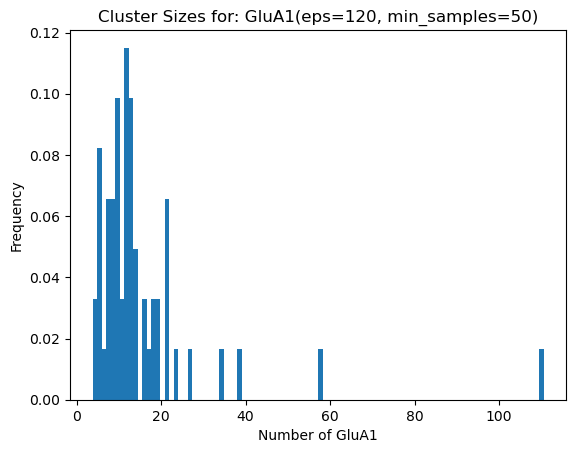

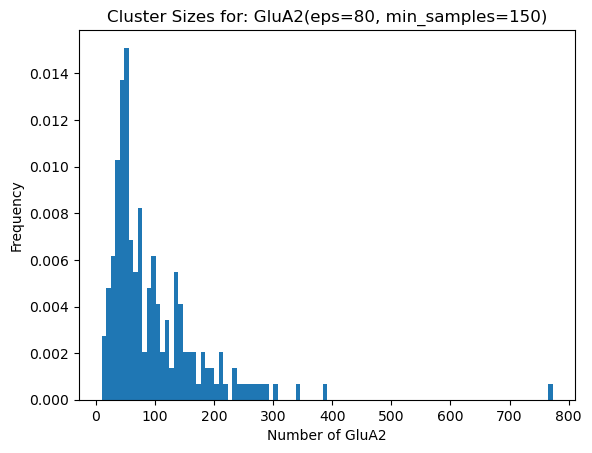

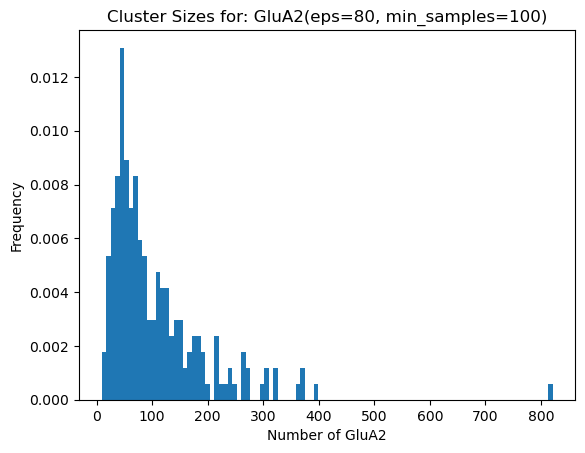

In [14]:
TestFOV.cluster_size_histogram(97.5, Params=Params, max_dark_time=100)

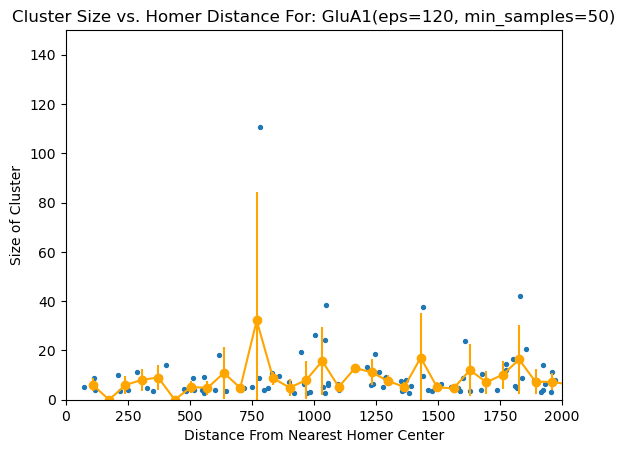

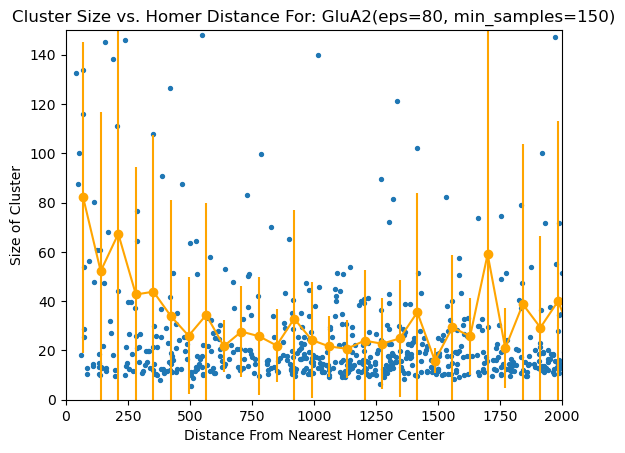

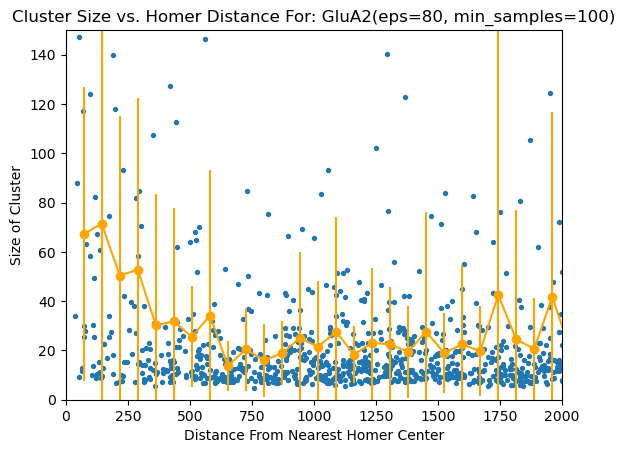

In [15]:
TestFOV.cluster_size_by_distance_to_homer_center(97.5, Params=Params, num_bins=150, y_top=150)

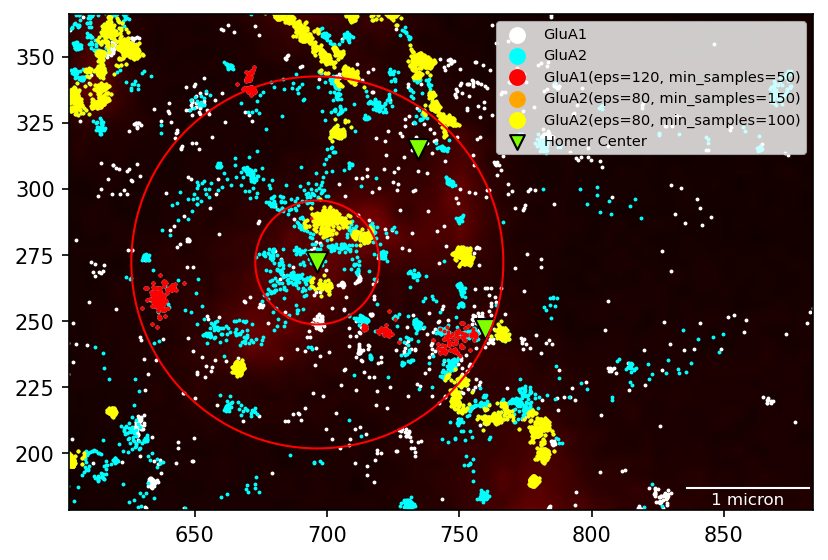

In [16]:
TestFOV.plot_homer(17, Params=Params, circle_radii=[500, 1500], show_points=['GluA1', 'GluA2'], other_homers=True)

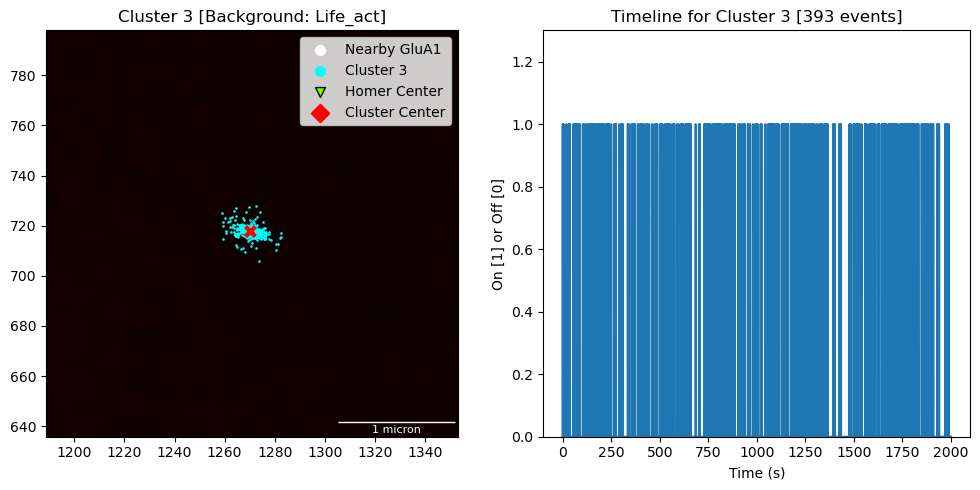

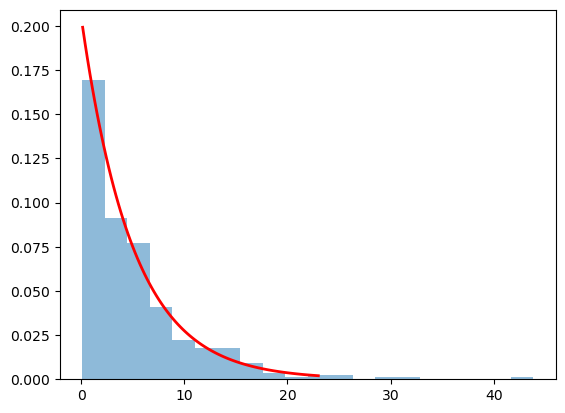

4.970153061224581

In [17]:
Param = Params[0]
cluster_index = 3
TestFOV.clustering_results[Param][cluster_index].plot(buffer=1500, nearby_points=True)
TestFOV.clustering_results[Param][cluster_index].frames.get_average_dark_time(plot=True)